In [ ]:
!pip install git+https://github.com/prolearner/hypertorch

  Cloning https://github.com/prolearner/hypertorch to /tmp/pip-req-build-yh8du9g0
  Running command git clone -q https://github.com/prolearner/hypertorch /tmp/pip-req-build-yh8du9g0
  Created wheel for hypergrad: filename=hypergrad-0.1-cp36-none-any.whl size=6648 sha256=e8d562d871bea65e98231bf7a39bbfdce0027cbd7fc8f6a81d4f193168160f5a
  Stored in directory: /tmp/pip-ephem-wheel-cache-i12slsoa/wheels/87/98/9c/443338661f6be492cbc5fb006151190595902bab536abc532c
Successfully built hypergrad


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import torch.nn.functional as F
import pickle
import itertools
import tqdm
import hypergrad as hg
from mlmodel import *
import utils
import torch.nn.functional as F
import numpy as np
from sparsemax import Sparsemax

In [ ]:
sineRegress = FuncRecursiveNet([
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(40, True),
        FActivation(F.relu),
        FLinearLayer(1, True)
    ])

In [ ]:
def getPred(x_loss, w_pred, model_shape):

  reshaped_w = utils.reshape_w(w_pred, model_shape)       
  pred_y = sineRegress(reshaped_w, x_loss)

  return pred_y

def outer_loss(w, x_loss, y_loss, model_shape):
  #print('params shape', params[0].shape)
  pred_y = getPred(x_loss, w, model_shape)
  
  o_loss = F.mse_loss(pred_y, y_loss)
  
  return o_loss

def taskVisualize(item, model_shape):
  attribute = item[0].squeeze()
  print(attribute)
  weights = item[1]
  x = item[2]
  y = item[3]

  reshaped_w = utils.reshape_w(weights, model_shape)       
  pred_y = sineRegress(reshaped_w, x)
  print('pred_y shape', pred_y.size())
  loss = F.mse_loss(pred_y, y)

  print('Amplitude A={}, Frequency f={}, phase={}pi, pred loss={}'.format(attribute[0], attribute[1], attribute[2]/np.pi, loss))

  plt.plot(x, pred_y, '.', c='r', label='pred')
  plt.plot(x, y, '.', c='b', label='gt')
  plt.xlabel('Radian')
  plt.ylabel('Magitude')
  plt.legend()
  plt.show()


In [ ]:
kb_size = 24
train_size = 90

In [ ]:
filename = 'sineWave_xl.p'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
total_len = len(dataset)
test_size = total_len - kb_size - train_size

flatted_param, shape_record = utils.flattenParam(dataset[0])

#data = Dataset(dataset)
indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
#print(temp)
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
# val_indx = list(np.random.choice(temp, size=55, replace=False))
test_indx = temp
print(len(test_indx))

support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])


24
90
30


In [ ]:
support_loader = DataLoader(support_data, batch_size=10, shuffle=False)
train_loader = DataLoader(train_data, batch_size=train_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_size, shuffle=True)
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
print(support_a.size(), support_w.size(), support_x.size(), support_y.size())

torch.Size([10, 1, 3]) torch.Size([10, 1, 1761]) torch.Size([10, 200, 1]) torch.Size([10, 200, 1])


tensor([1.4000, 1.0000, 0.7854])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=0.25pi, pred loss=3.0198066587441613e-16


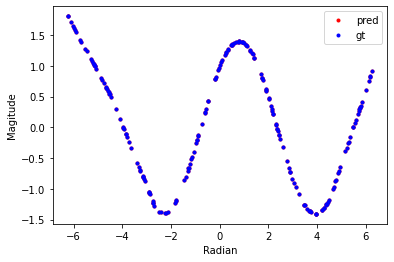

In [ ]:
#test visualization and rehspae uitls
item = [support_a[0,:].float(), support_w[0,:].float(), support_x[0,:].float(), support_y[0,:].float()]
taskVisualize(item, shape_record)

In [ ]:
def analytical_soln_atten(w_kbb, e_item, e_kbb, w_atten):
  #find analytical son for one specific novel task
  '''
  c - row vector 
  w_kbb 
  '''
  affinity = build_c_byAtten(e_item, e_kbb, w_atten)
  #print('affinity ',affinity.size())
  softmax = Sparsemax(dim=1)
  c_newnew = softmax(affinity) 
  #print('check softmax sum ', torch.sum(c_newnew, dim=1, keepdim=True))
  w = torch.matmul(c_newnew, w_kbb.t())

  return w.t()

def build_c_byAtten(e_item, e_kbb, w_atten):
  dim = e_item.size()[0]
  #print('dim ', dim)
  affinity = torch.matmul(e_item.t(), w_atten)
  affinity = torch.matmul(affinity, e_kbb)
  
  #torch.sqrt(torch.tensor(e_item.size()[0], dtype=float))

  return affinity


In [ ]:
w_atten = torch.eye(support_a.size()[2])
w = analytical_soln_atten(support_w.squeeze().t(), support_a.squeeze().t()[:,0:3], support_a.squeeze().t(), w_atten)
print('w ', w.size())

w  torch.Size([1761, 3])


In [ ]:
def getPred_batch(x,  weight, model_shape):
  pred_y_batch = []
  batch_size = weight.size()[1]
  for t in range(batch_size):
    cur_x = x[t,:].float()
    cur_w = weight[:,t].unsqueeze(0).float()
    pred_y = getPred(cur_x, cur_w, model_shape)
    pred_y_batch.append(pred_y.t())

  pred_y_batch = torch.cat(pred_y_batch, dim=0)
  return pred_y_batch

def outer_loss_batch(weight, x, y, model_shape):
  o_loss = torch.tensor(0.0, requires_grad=True, dtype=float)
  batch_size = weight.size()[1]
  for t in range(batch_size):
    cur_x = x[t,:].float()
    cur_w = weight[:,t].unsqueeze(0).float()
    cur_y = y[t,:]
    o_loss = o_loss + outer_loss(cur_w, cur_x, cur_y, model_shape)

  return o_loss/batch_size

def getPred_batch(x,  weight, model_shape):
  pred_y_batch = []
  batch_size = weight.size()[1]
  for t in range(batch_size):
    cur_x = x[t,:].float()
    cur_w = weight[:,t].unsqueeze(0).float()
    pred_y = getPred(cur_x, cur_w, model_shape)
    pred_y_batch.append(pred_y.t())

  pred_y_batch = torch.cat(pred_y_batch, dim=0)
  return pred_y_batch

def attention_alignment(weight_train, weight_kb, attr_train, attr_kb, x_loss, model_shape):
  cal_affinity = lambda a, b: torch.exp(torch.matmul(a, b)/torch.sqrt(torch.tensor(b.size()[0], dtype=float)))
  cal_atten = lambda a : a/torch.sum(a, dim=1, keepdim=True)
  
  attr_kb_opt = [attr_kb.clone().detach().requires_grad_(True)]
  opt = torch.optim.Adam(attr_kb_opt, lr=1e-3)

  totIter = 200

  y_kb_pred = getPred_batch(x_loss,  weight_kb, model_shape)
  #print('y_kb_pred shape', y_kb_pred.size())
  affinity_y_kb = cal_affinity(y_kb_pred, y_kb_pred.t())
  #print('affinity_w_kb ', affinity_y_kb.size()) 
  y_kb_atten = cal_atten(affinity_y_kb)
  #print('y_kb_atten ', y_kb_atten.size(), torch.sum(y_kb_atten, dim=1))

  y_train_pred = getPred_batch(x_loss,  weight_train, model_shape)
  #print('y_train_pred shape', y_train_pred.size())
  affinity_y_train_kb = cal_affinity(y_train_pred, y_kb_pred.t())
  #print('affinity_y_train_kb ', affinity_y_train_kb.size())
  
  y_train_kb_atten = cal_atten(affinity_y_train_kb)
  #print('y_train_kb_atten ', y_train_kb_atten.size(), torch.sum(y_train_kb_atten, dim=1))
  
  for t in range(totIter):
    affinity_attr_kb = cal_affinity(attr_kb_opt[0].t(), attr_kb_opt[0])
    attr_kb_atten = cal_atten(affinity_attr_kb)

    affinity_attr_train_kb = cal_affinity(attr_train.t(), attr_kb_opt[0])
    attr_train_kb_atten = cal_atten(affinity_attr_train_kb)

    loss = nn.MSELoss()
    mse_loss_kb =  loss(attr_kb_atten, y_kb_atten)
    mse_loss_train_kb = loss(attr_train_kb_atten, y_train_kb_atten)
    mse_loss = mse_loss_kb + mse_loss_train_kb + 0.00001*torch.pow(torch.norm(attr_kb_opt[0]), 2)
    
    opt.zero_grad()
    tt = torch.autograd.grad(mse_loss, attr_kb_opt, retain_graph=True)
    mse_loss.backward()
    opt.step()
  #print('{}/{}: mse loss is {}'.format(t, totIter, mse_loss))
  return attr_kb_opt[0].clone().detach().requires_grad_(False), mse_loss

In [ ]:
train_batch = next(iter(train_loader))
train_a, train_w, train_x, train_y = train_batch[0].float(), train_batch[1].float(), train_batch[2].float(), train_batch[3].float()
print(train_a.size(), train_w.size(), train_x.size(), train_y.size())
train_a = train_a.squeeze().t()
train_w = train_w.squeeze().t()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()

torch.Size([90, 1, 3]) torch.Size([90, 1, 1761]) torch.Size([90, 200, 1]) torch.Size([90, 200, 1])


In [ ]:

#test batch outer loss
o_loss_batch = outer_loss_batch(train_w, train_x, train_y, shape_record)
print('o_loss_batch ', o_loss_batch)
a_kb_opt, mse_loss = attention_alignment(train_w, support_w, train_a, support_a, train_x, shape_record)
print('attention align ', mse_loss)

o_loss_batch  tensor(3.4142e-16, dtype=torch.float64, grad_fn=<DivBackward0>)


RuntimeError: ignored

In [ ]:
#data preparation
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()

test_batch = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_batch[0].float(), test_batch[1].float(), test_batch[2].float(), test_batch[3].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()

dm = support_a.size()[0]

init mean test loss 0.9638461793462435;
10/2000 o_loss 1.1384678633676635; mean test loss 1.0390705734491348 with mse loss in atten align 0.04997512698173523
20/2000 o_loss 0.8814830852051576; mean test loss 0.8021413564682007 with mse loss in atten align 0.03739967197179794
30/2000 o_loss 0.7352908512370454; mean test loss 0.6591653894633055 with mse loss in atten align 0.0346747487783432
40/2000 o_loss 0.6780038786017233; mean test loss 0.640760542328159 with mse loss in atten align 0.03528878837823868
50/2000 o_loss 0.6002553769283825; mean test loss 0.6235630977898836 with mse loss in atten align 0.037223394960165024
60/2000 o_loss 0.5340349500377972; mean test loss 0.5767656087875366 with mse loss in atten align 0.036387357860803604
70/2000 o_loss 0.5073104683723715; mean test loss 0.5363083316634099 with mse loss in atten align 0.035296253859996796
80/2000 o_loss 0.4866926373499963; mean test loss 0.5046212849517663 with mse loss in atten align 0.03526774421334267
90/2000 o_loss 

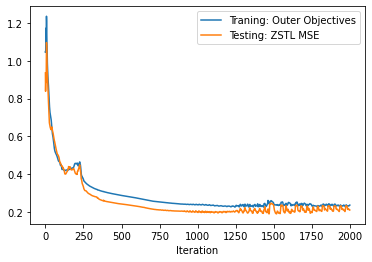

In [ ]:
hp = [torch.eye(dm, requires_grad=True), support_w.clone().detach().requires_grad_(True)]
a_kb_opt = support_a.clone().detach().requires_grad_(False)
lr = 5e-4
opt_hp = torch.optim.Adam(hp, lr=lr)

totIter = 2000
test_w_pred = analytical_soln_atten(hp[1], test_a, a_kb_opt, hp[0])
test_loss_batch = outer_loss_batch(test_w_pred, test_x, test_y, shape_record)
print('init mean test loss {};'.format(test_loss_batch))

train_l_lst = []
test_l_lst = []
for i in range(totIter):

  train_batch = next(iter(train_loader))
  train_a, train_w, train_x, train_y = train_batch[0].float(), train_batch[1].float(), train_batch[2].float(), train_batch[3].float()
  train_a = train_a.squeeze().t()
  train_w = train_w.squeeze().t()
  #print(train_a.size(), train_w.size(), train_x.size(), train_y.size())

  train_w_pred = analytical_soln_atten(hp[1], train_a, a_kb_opt, hp[0])
  #print('train_w_pred ', train_w_pred.size())
  train_loss_batch = outer_loss_batch(train_w_pred, train_x, train_y, shape_record)

  o_loss = train_loss_batch + 0.0001*torch.pow(torch.norm(hp[1]), 2)
  train_l_lst.append(utils.toNumpy(o_loss.clone().detach().requires_grad_(False)))
  opt_hp.zero_grad()
  o_loss.backward()
  opt_hp.step()

  a_kb_opt, mse_loss = attention_alignment(train_w, hp[1].clone().detach().requires_grad_(False), train_a, a_kb_opt, train_x, shape_record)

  test_w_pred = analytical_soln_atten(hp[1], test_a, a_kb_opt, hp[0])
  test_loss_batch = outer_loss_batch(test_w_pred, test_x, test_y, shape_record)
  test_l_lst.append(utils.toNumpy(test_loss_batch.clone().detach().requires_grad_(False)))

  if (i+1) % 10 == 0:
    print('{}/{} o_loss {}; mean test loss {} with mse loss in atten align {}'.format(i+1, totIter, o_loss, test_loss_batch, mse_loss))
print('lr ', lr)
plt.plot(train_l_lst, label='Traning: Outer Objectives')
plt.plot(test_l_lst, label='Testing: ZSTL MSE')
plt.xlabel('Iteration')
plt.legend()
plt.show()

tensor([1.6000, 1.0000, 0.3927])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.125pi, pred loss=0.03885000944137573


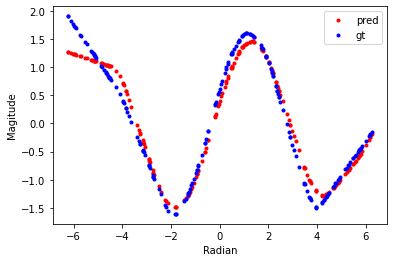

tensor([1.6000, 1.0000, 5.1051])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=1.625pi, pred loss=0.15185408294200897


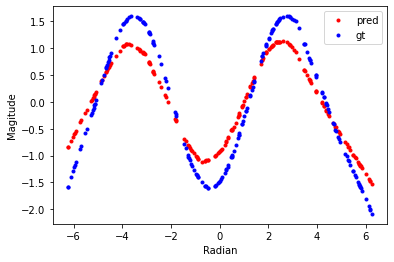

tensor([1.0000, 1.0000, 1.9635])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.625pi, pred loss=0.016901427879929543


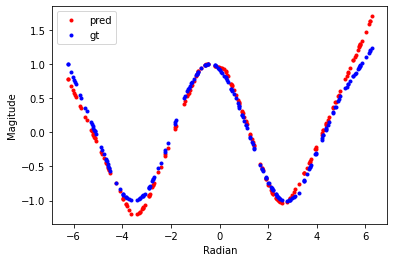

tensor([0.4000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.5pi, pred loss=0.3231942355632782


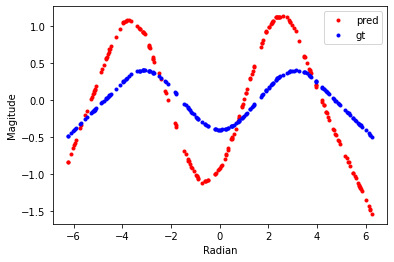

tensor([1.8000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=1.7999999523162842, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.35860320925712585


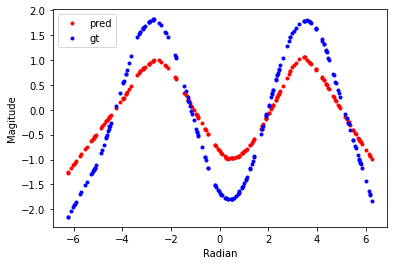

tensor([1.4000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.0pi, pred loss=0.06881595402956009


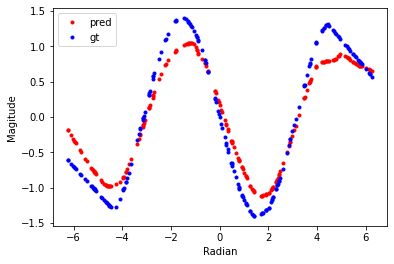

tensor([0.4000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.218259796500206


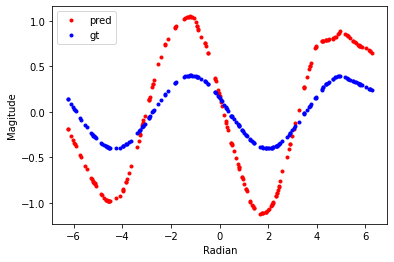

tensor([2.0000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=0.75pi, pred loss=0.6422607898712158


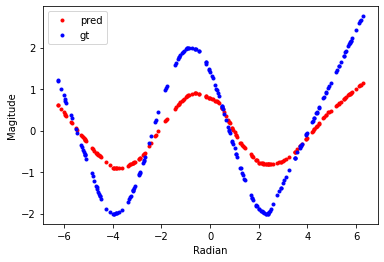

tensor([2.0000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.423737496137619


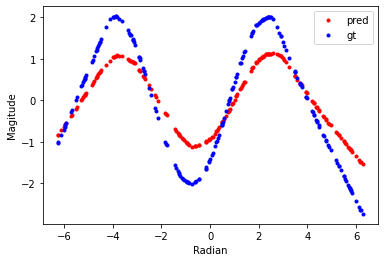

tensor([1.2000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.05157212167978287


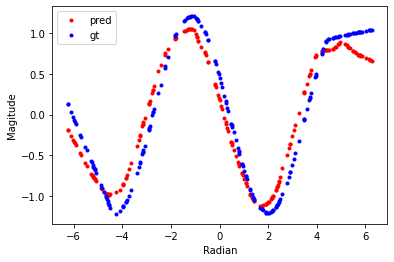

tensor([1.0000, 1.0000, 5.4978])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=1.7499998807907104pi, pred loss=0.03326410427689552


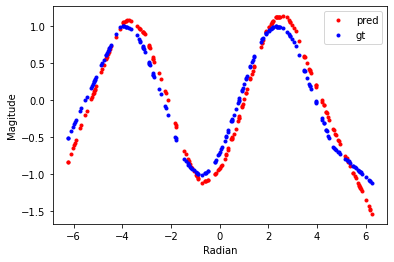

tensor([1.4000, 1.0000, 5.8905])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.875pi, pred loss=0.30310043692588806


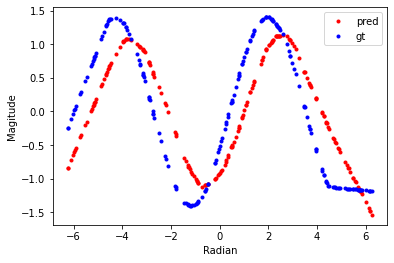

tensor([2.0000, 1.0000, 4.3197])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.3749998807907104pi, pred loss=0.5715692043304443


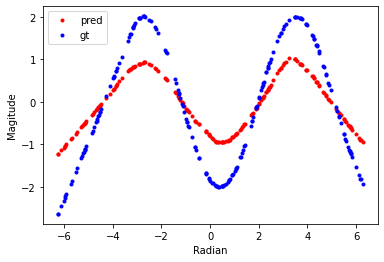

tensor([1.2000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.125pi, pred loss=0.20771154761314392


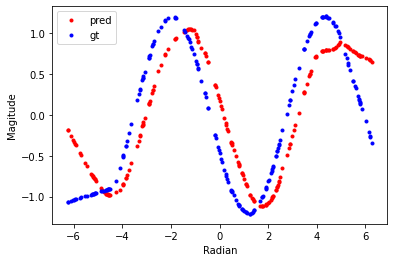

tensor([1.6000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=1.600000023841858, Frequency f=1.0, phase=0.5pi, pred loss=0.19164510071277618


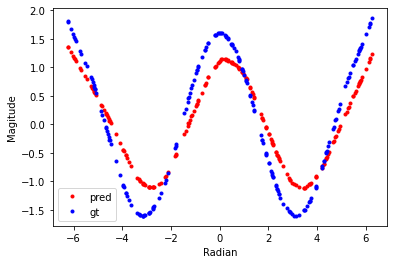

tensor([1.4000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=1.399999976158142, Frequency f=1.0, phase=1.125pi, pred loss=0.22621765732765198


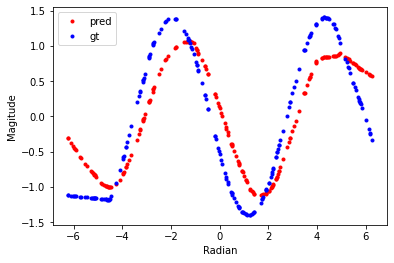

tensor([0.6000, 1.0000, 0.0000])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.0pi, pred loss=0.3438549041748047


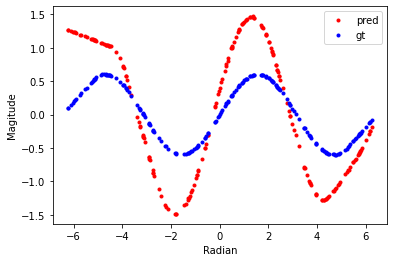

tensor([0.8000, 1.0000, 2.7489])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.8749999403953552pi, pred loss=0.05709708854556084


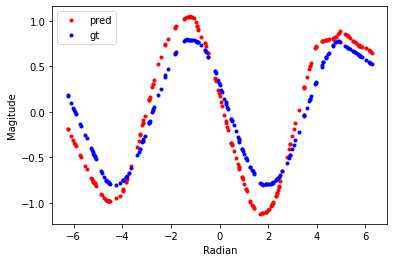

tensor([0.8000, 1.0000, 4.7124])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=1.5pi, pred loss=0.18228580057621002


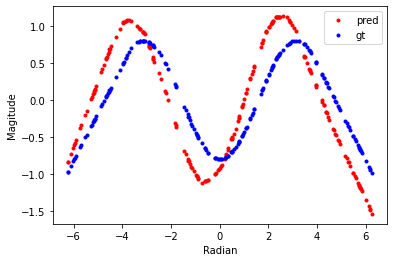

tensor([0.8000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.5pi, pred loss=0.07659277319908142


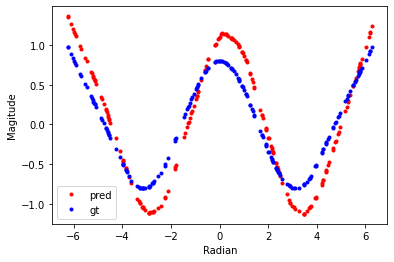

tensor([0.6000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=1.125pi, pred loss=0.19867683947086334


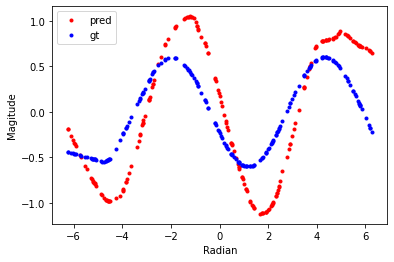

tensor([0.4000, 1.0000, 3.5343])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.125pi, pred loss=0.27155500650405884


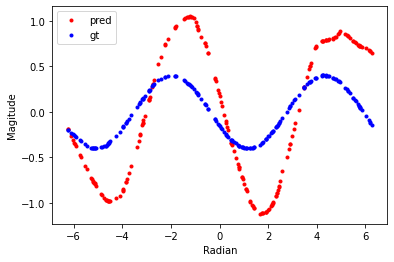

tensor([2.0000, 1.0000, 3.1416])
pred_y shape torch.Size([200, 1])
Amplitude A=2.0, Frequency f=1.0, phase=1.0pi, pred loss=0.391580194234848


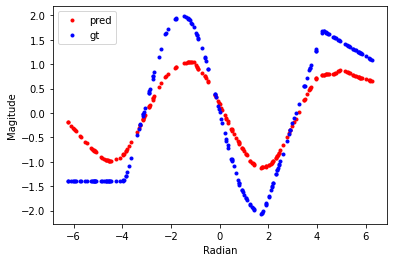

tensor([1.2000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=1.25pi, pred loss=0.025533877313137054


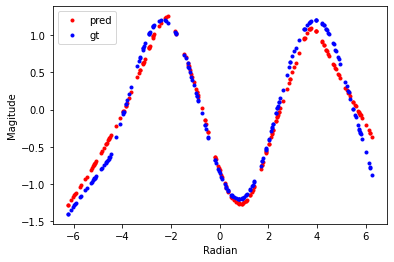

tensor([0.4000, 1.0000, 3.9270])
pred_y shape torch.Size([200, 1])
Amplitude A=0.4000000059604645, Frequency f=1.0, phase=1.25pi, pred loss=0.3453808128833771


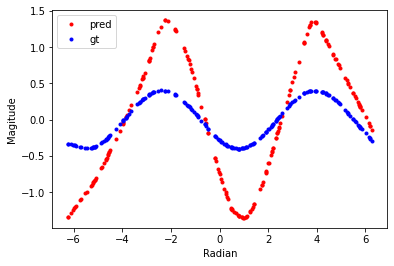

tensor([1.2000, 1.0000, 1.5708])
pred_y shape torch.Size([200, 1])
Amplitude A=1.2000000476837158, Frequency f=1.0, phase=0.5pi, pred loss=0.05354444682598114


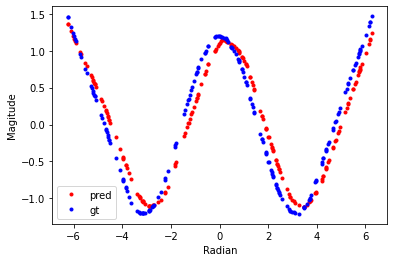

tensor([0.8000, 1.0000, 0.7854])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.25pi, pred loss=0.16017605364322662


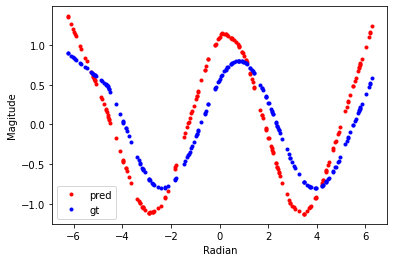

tensor([0.6000, 1.0000, 0.3927])
pred_y shape torch.Size([200, 1])
Amplitude A=0.6000000238418579, Frequency f=1.0, phase=0.125pi, pred loss=0.08100686222314835


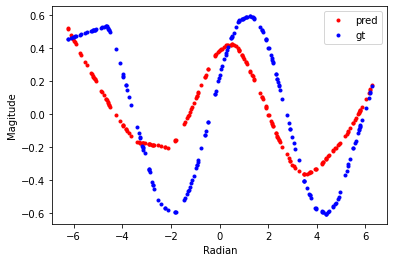

tensor([0.8000, 1.0000, 1.1781])
pred_y shape torch.Size([200, 1])
Amplitude A=0.800000011920929, Frequency f=1.0, phase=0.375pi, pred loss=0.05425863713026047


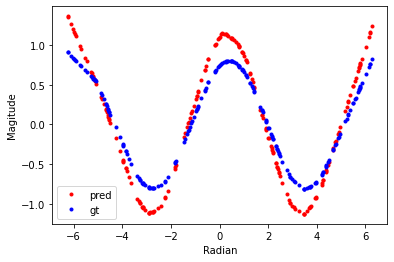

tensor([1.0000, 1.0000, 2.3562])
pred_y shape torch.Size([200, 1])
Amplitude A=1.0, Frequency f=1.0, phase=0.75pi, pred loss=0.21239528059959412


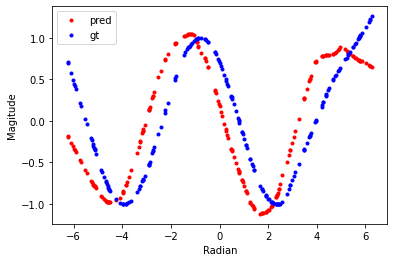

In [ ]:
test_batch_size = test_a.size()[ 1]
tt_w = test_w_pred.clone().detach()
for t in range(test_batch_size):
  item = [test_a[:,t].float(), tt_w[:,t].float().unsqueeze(0), test_x[t,:].float(), test_y[t,:].float()]
  taskVisualize(item, shape_record)

In [ ]:
kb_size = 10
train_size = 90

filename = 'sineWave_xxl.p'
with open(filename, 'rb') as f:
    dataset = pickle.load(f)
total_len = len(dataset)
print('total_len ', total_len)
a = ppp
test_size = total_len - kb_size - train_size

flatted_param, shape_record = utils.flattenParam(dataset[0])

#data = Dataset(dataset)
indx = [ x for x in range(len(dataset))]
support_indx = list(np.random.choice(indx, size=kb_size, replace=False))
print(len(support_indx))
temp = [x for x in indx if x not in support_indx]
#print(temp)
train_indx = list(np.random.choice(temp, size=train_size, replace=False))
temp = [x for x in temp if x not in train_indx]
print(len(train_indx))
# val_indx = list(np.random.choice(temp, size=55, replace=False))
test_indx = temp
print(len(test_indx))

support_data = utils.Dataset([dataset[d] for d in support_indx])
train_data = utils.Dataset([dataset[d] for d in train_indx])
test_data = utils.Dataset([dataset[d] for d in test_indx])

In [ ]:
#data preparation
support_a, support_w, support_x, support_y = next(iter(support_loader))
support_a, support_w, support_x, support_y = support_a.float(), support_w.float(), support_x.float(), support_y.float()
support_a = support_a.squeeze().t()
support_w = support_w.squeeze().t()

test_batch = next(iter(test_loader))
test_a, test_w, test_x, test_y = test_batch[0].float(), test_batch[1].float(), test_batch[2].float(), test_batch[3].float()
test_a = test_a.squeeze().t()
test_w = test_w.squeeze().t()

dm = support_a.size()[0]

hp = [torch.eye(dm, requires_grad=True), support_w.clone().detach().requires_grad_(True)]
a_kb_opt = support_a.clone().detach().requires_grad_(False)
opt_hp = torch.optim.Adam(hp, lr=1e-3)

totIter = 3000
test_w_pred = analytical_soln_atten(hp[1], test_a, a_kb_opt, hp[0])
test_loss_batch = outer_loss_batch(test_w_pred, test_x, test_y, shape_record)
print('init mean test loss {};'.format(test_loss_batch))

train_l_lst = []
test_l_lst = []
for i in range(totIter):

  train_batch = next(iter(train_loader))
  train_a, train_w, train_x, train_y = train_batch[0].float(), train_batch[1].float(), train_batch[2].float(), train_batch[3].float()
  train_a = train_a.squeeze().t()
  train_w = train_w.squeeze().t()
  #print(train_a.size(), train_w.size(), train_x.size(), train_y.size())

  train_w_pred = analytical_soln_atten(hp[1], train_a, a_kb_opt, hp[0])
  #print('train_w_pred ', train_w_pred.size())
  train_loss_batch = outer_loss_batch(train_w_pred, train_x, train_y, shape_record)

  o_loss = train_loss_batch + 0.0005*torch.pow(torch.norm(hp[1]), 2)
  train_l_lst.append(utils.toNumpy(o_loss.clone().detach().requires_grad_(False)))
  opt_hp.zero_grad()
  o_loss.backward()
  opt_hp.step()

  a_kb_opt, mse_loss = attention_alignment(train_w, hp[1].clone().detach().requires_grad_(False), train_a, a_kb_opt, train_x, shape_record)

  test_w_pred = analytical_soln_atten(hp[1], test_a, a_kb_opt, hp[0])
  test_loss_batch = outer_loss_batch(test_w_pred, test_x, test_y, shape_record)
  test_l_lst.append(utils.toNumpy(test_loss_batch.clone().detach().requires_grad_(False)))

  if (i+1) % 10 == 0:
    print('{}/{} o_loss {}; mean test loss {} with mse loss in atten align {}'.format(i+1, totIter, o_loss, test_loss_batch, mse_loss))

plt.plot(train_l_lst, label='Traning: Outer Objectives')
plt.plot(test_l_lst, label='Testing: ZSTL MSE')
plt.xlabel('Iteration')
plt.legend()
plt.show()

In [ ]:
test_batch_size = test_a.size()[ 1]
tt_w = test_w_pred.clone().detach()
for t in range(test_batch_size):
  item = [test_a[:,t].float(), tt_w[:,t].float().unsqueeze(0), test_x[t,:].float(), test_y[t,:].float()]
  taskVisualize(item, shape_record)